In [ ]:
# Start writing code here...

### `Note`
When PyCaret Setup function is called it expects user input and will wait for you to confirm if the feature types inferred are correct. So hit enter upon confirming detected types.

In [ ]:
#!pip install pycaret[full] 
#Restart kernel

  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached charset_normalizer-2.0.12-py3-none-any.whl (39 kB)
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Not uninstalling jinja2 at /shared-libs/python3.9/py-core/lib/python3.9/site-packages, outside environment /root/venv
    Can't uninstall 'Jinja2'. No files were found to uninstall.
  Attempting uninstall: charset-normalizer
    Found existing installation: charset-normalizer 2.1.0
    Not uninstalling charset-normalizer at /shared-libs/python3.9/py-core/lib/python3.9/site-packages, outside environment /root/venv
    Can't uninstall 'charset-normalizer'. No files were found to uninstall.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.3.0 requires grpcio<2.0dev,>=1.47.0, but you have grpcio 1.43.0 which is incompatible.
You should consider

In [1]:
import sys
sys.path.append('..')

import os
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
from  sklearn.svm import SVR

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.utils.validation import check_is_fitted
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion

from sklearn import set_config
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression



from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV

import xgboost
from xgboost import XGBRegressor

from lib.viz import draw_histogram, create_silhoutte_cluster_viz
from lib.unsupervised import kmeans_parameters_search

from lib.supervised_tuning import FeatureTTRegressor, final_comparison, add_cluster_label, print_scores, predict_score_base_regressors, predict_mean_squared_error_regression, read_target_shifted_data, read_target_shifted_pca_data

from matplotlib import pyplot as plt
from xgboost import plot_importance

%matplotlib inline


/root/venv/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
RANDOM_SEED = 42

## Load numpy arrays and dataframes from pickle files

In [3]:
data_dir = "../assets/train_test_target_shifted/"
train_test_dict_file_name = "train_test_dict_target_shifted.pickle"
X_train_df_file_name = "X_train_impute_target_shifted_df.pkl"
X_test_df_file_name = "X_test_impute_target_shifted_df.pkl"

train_test_dict, X_train_impute_df, X_test_impute_df = read_target_shifted_data(
    data_dir, train_test_dict_file_name, X_train_df_file_name, X_test_df_file_name
)
X_train_impute = train_test_dict["X_train_impute"]
X_test_impute = train_test_dict["X_test_impute"]
y_train = train_test_dict["y_train"]
y_test = train_test_dict["y_test"]


## [Understand the distribution of the target](https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html)

In [4]:
draw_histogram(pd.DataFrame(y_train.reset_index()), "GSE_GWE_SHIFTED" ) 

alt.LayerChart(...)

## [Normalize the target to improve accuracy](https://anshikaaxena.medium.com/how-skewed-data-can-skrew-your-linear-regression-model-accuracy-and-transfromation-can-help-62c6d3fe4c53)




In [5]:
#We will view the variables with sqrt applied but we do not need these in the model since 
# we will be using TransformedTargetRegressor to wrap models to aid with Cross Validations
y_train_sqrt = np.sqrt(train_test_dict['y_train'])
y_test_sqrt = np.sqrt(train_test_dict['y_test'])
draw_histogram(pd.DataFrame(y_train_sqrt.reset_index()), "GSE_GWE_SHIFTED" ) 

alt.LayerChart(...)

#### Crop Code to Crop Name mapping

[Crop to Code mapping](https://github.com/mlnrt/milestone2_waterwells_data/blob/main/crops/crop_name_to_type_mapping.json)

### PyCaret Experimentations

Pycaret Full overrides the currently set libraries in the Docker container.
If placed in the reuirements.txt file, the project takes very long to start up and so this library is only installed for this notebook for all the experimentations.

1. Start the machine/project
2. Run pip install for pycaret[full]   [This can take anywhere from 10 mins to 20 mins)
3. Once the library is installed, restart the kernel for the notebook.
4. Run the cells above once again.

In [6]:
#This might need restart of the kernel
from pycaret.regression import *

train_data = pd.concat([X_train_impute_df, y_train], axis=1)
test_data = pd.concat([X_test_impute_df, y_test], axis=1)
#_= test_data.hist(figsize=(100,100))

#### Run PyCaret experiment  by ignoring low variance and remove multi-collinearity

In [7]:
# We already have an imputed and scaled train and test, we do not want to preprocess
target_normalized_exp = setup(
    train_data,
    target="GSE_GWE_SHIFTED",
    preprocess=False,
    #Transform the target
    transform_target= True,
    remove_multicollinearity = True,
    multicollinearity_threshold=0.1,
    #Low Variance in feature
    ignore_low_variance=True,
    train_size=1.0,
    test_data=test_data,
    session_id=RANDOM_SEED,
    log_experiment=True,
    experiment_name="water_depth_shifted",
)

,Description,Value
0,session_id,42
1,Target,GSE_GWE_SHIFTED
2,Original Data,"(2868, 45)"
3,Missing Values,False
4,Numeric Features,44
5,Categorical Features,0
6,Transformed Train Set,"(2868, 44)"
7,Transformed Test Set,"(478, 44)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


Traceback (most recent call last):
  File "/root/venv/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 270, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/root/venv/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 394, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/root/venv/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 1049, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
  File "/root/venv/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 1042, in _read_helper
    result = read_yaml(root, file_name)
  File "/root/venv/lib/python3.9/site-packages/mlflow/utils/file_utils.py", line 181, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/work/milestone2_waterwells_deepnote/m

In [8]:
compare_best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,29.3993,3107.3674,50.1816,0.7712,0.3135,0.2450,1.1670
catboost,CatBoost Regressor,31.7454,3316.8908,51.8649,0.7555,0.3320,0.2818,9.8700
rf,Random Forest Regressor,31.0642,3298.0181,52.1870,0.7491,0.3225,0.2512,3.5820
lightgbm,Light Gradient Boosting Machine,32.5746,3475.3938,53.7225,0.7415,0.3289,0.2678,5.6470
xgboost,Extreme Gradient Boosting,34.0889,3760.3022,55.2154,0.7230,0.3342,0.2645,1.1110
et,Extra Trees Regressor,32.8742,3782.4370,55.6023,0.7230,0.3393,0.2728,1.9820
ada,AdaBoost Regressor,41.6488,4919.7455,62.1663,0.6600,0.4281,0.4341,0.3680
lr,Linear Regression,38.6800,4199.1055,60.1087,0.6485,0.4316,0.4231,0.2580
ridge,Ridge Regression,38.8160,4317.8576,60.7400,0.6452,0.4248,0.4370,0.2670
br,Bayesian Ridge,38.8531,4320.7928,60.7649,0.6450,0.4256,0.4395,0.4550


INFO:logs:create_model_container: 19
INFO:logs:master_model_container: 19
INFO:logs:display_container: 2
INFO:logs:PowerTransformedTargetRegressor(alpha=0.9, ccp_alpha=0.0,
                                criterion='friedman_mse', init=None,
                                learning_rate=0.1, loss='ls', max_depth=3,
                                max_features=None, max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None, min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_estimators=100,
                                n_iter_no_change=None,
                                power_transformer_method...
                                                                    max_leaf_nodes=None,
                                                                    min_impurity_decrease=0.0,
                                           

### Narrow down the algorithms using above comparison. algorithms with MAE less than 40 or close to 40 have been chosen from above list

In [9]:
pick_best_model = compare_models(['gbr', 'catboost', 'et', 'lightgbm', 'rf', 'knn', 'xgboost',  'svm', 'ada', 'lr'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,29.3993,3107.3674,50.1816,0.7712,0.3135,0.2450,1.2020
catboost,CatBoost Regressor,31.7454,3316.8908,51.8649,0.7555,0.3320,0.2818,9.8300
rf,Random Forest Regressor,31.0642,3298.0181,52.1870,0.7491,0.3225,0.2512,3.6040
lightgbm,Light Gradient Boosting Machine,32.5746,3475.3938,53.7225,0.7415,0.3289,0.2678,5.2040
svm,Support Vector Regression,32.4098,3472.7730,53.2588,0.7413,0.3631,0.3318,0.4970
et,Extra Trees Regressor,32.8742,3782.4370,55.6023,0.7230,0.3393,0.2728,1.9710
xgboost,Extreme Gradient Boosting,34.0889,3760.3022,55.2154,0.7230,0.3342,0.2645,1.0960
ada,AdaBoost Regressor,41.6488,4919.7455,62.1663,0.6600,0.4281,0.4341,0.3680
lr,Linear Regression,38.6800,4199.1055,60.1087,0.6485,0.4316,0.4231,0.2390
knn,K Neighbors Regressor,44.9301,4460.1374,62.9773,0.6179,0.4858,0.5561,0.0590


INFO:logs:create_model_container: 29
INFO:logs:master_model_container: 29
INFO:logs:display_container: 3
INFO:logs:PowerTransformedTargetRegressor(alpha=0.9, ccp_alpha=0.0,
                                criterion='friedman_mse', init=None,
                                learning_rate=0.1, loss='ls', max_depth=3,
                                max_features=None, max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None, min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_estimators=100,
                                n_iter_no_change=None,
                                power_transformer_method...
                                                                    max_leaf_nodes=None,
                                                                    min_impurity_decrease=0.0,
                                           

In [10]:
best_model_created = create_model(pick_best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,8.8765,323.0165,17.9727,0.8605,0.2854,0.2366
1,12.4955,473.0545,21.7498,0.8591,0.2822,0.2019
2,15.4822,792.1656,28.1454,0.7693,0.2927,0.2426
3,35.2900,3234.5406,56.8730,0.8622,0.3800,0.2705
4,26.8438,1689.4051,41.1024,0.8759,0.3566,0.3849
5,39.6944,6275.0347,79.2151,0.6519,0.3175,0.2159
6,26.8678,1954.2909,44.2074,0.8812,0.1976,0.1479
7,30.5809,1877.3262,43.3281,0.7708,0.2265,0.1631
8,53.7427,8627.0185,92.8817,0.6937,0.3197,0.2464


INFO:logs:create_model_container: 30
INFO:logs:master_model_container: 30
INFO:logs:display_container: 4
INFO:logs:PowerTransformedTargetRegressor(alpha=0.9, ccp_alpha=0.0,
                                criterion='friedman_mse', init=None,
                                learning_rate=0.1, loss='ls', max_depth=3,
                                max_features=None, max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None, min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_estimators=100,
                                n_iter_no_change=None,
                                power_transformer_method...
                                                                    max_leaf_nodes=None,
                                                                    min_impurity_decrease=0.0,
                                           

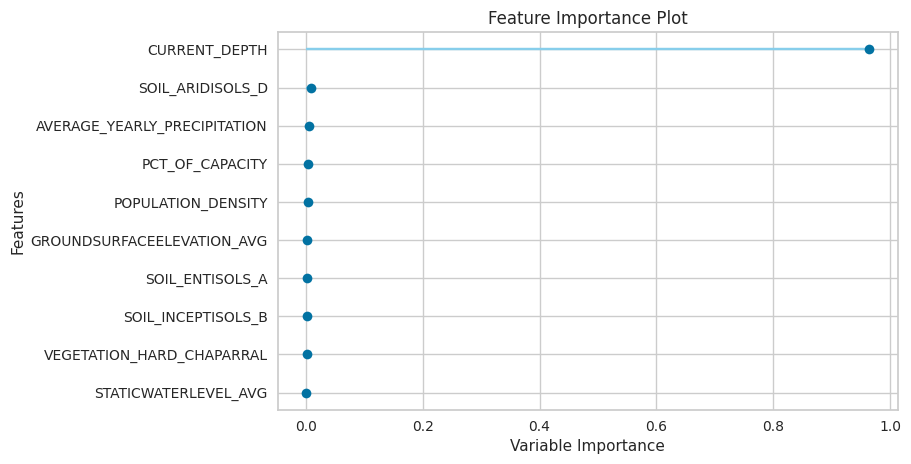

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [11]:
plot_model(best_model_created, plot='feature')

In [12]:
best_gbr_model = create_model('gbr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,8.8765,323.0165,17.9727,0.8605,0.2854,0.2366
1,12.4955,473.0545,21.7498,0.8591,0.2822,0.2019
2,15.4822,792.1656,28.1454,0.7693,0.2927,0.2426
3,35.2900,3234.5406,56.8730,0.8622,0.3800,0.2705
4,26.8438,1689.4051,41.1024,0.8759,0.3566,0.3849
5,39.6944,6275.0347,79.2151,0.6519,0.3175,0.2159
6,26.8678,1954.2909,44.2074,0.8812,0.1976,0.1479
7,30.5809,1877.3262,43.3281,0.7708,0.2265,0.1631
8,53.7427,8627.0185,92.8817,0.6937,0.3197,0.2464


INFO:logs:create_model_container: 31
INFO:logs:master_model_container: 31
INFO:logs:display_container: 5
INFO:logs:PowerTransformedTargetRegressor(alpha=0.9, ccp_alpha=0.0,
                                criterion='friedman_mse', init=None,
                                learning_rate=0.1, loss='ls', max_depth=3,
                                max_features=None, max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None, min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_estimators=100,
                                n_iter_no_change=None,
                                power_transformer_method...
                                                                    max_leaf_nodes=None,
                                                                    min_impurity_decrease=0.0,
                                           

In [13]:
tuned_model = tune_model(best_gbr_model, choose_better=True)
#                    MAE    MSE         RMSE     R2      RMSLE   MAPE          
#With fold=51 Mean	27.3396	2500.5448	42.5812	0.7668	0.2940	0.2482
#With no fold Mean	29.1872	2945.1679	49.1265	0.7782	0.3208	0.2643

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,11.4243,376.0859,19.3929,0.8376,0.2951,0.2528
1,16.7705,623.5044,24.9701,0.8143,0.3155,0.2554
2,19.6040,1037.9425,32.2171,0.6977,0.3264,0.2780
3,39.3843,3380.9066,58.1456,0.8560,0.3919,0.2849
4,27.0192,1643.2701,40.5373,0.8793,0.3498,0.3672
5,44.9973,6701.3350,81.8617,0.6283,0.3423,0.2649
6,29.6478,2098.1594,45.8057,0.8724,0.2089,0.1604
7,33.6827,2103.7132,45.8663,0.7432,0.2368,0.1741
8,59.1740,9638.1261,98.1740,0.6578,0.3362,0.2665


INFO:logs:create_model_container: 33
INFO:logs:master_model_container: 33
INFO:logs:display_container: 6
INFO:logs:PowerTransformedTargetRegressor(alpha=0.9, ccp_alpha=0.0,
                                criterion='friedman_mse', init=None,
                                learning_rate=0.1, loss='ls', max_depth=3,
                                max_features=None, max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None, min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_estimators=100,
                                n_iter_no_change=None,
                                power_transformer_method...
                                                                    max_leaf_nodes=None,
                                                                    min_impurity_decrease=0.0,
                                           

In [14]:
# The tuned model does not as good a mean absolute error as best model and so
#sticking with best model from compare
print(best_gbr_model)

PowerTransformedTargetRegressor(alpha=0.9, ccp_alpha=0.0,
                                criterion='friedman_mse', init=None,
                                learning_rate=0.1, loss='ls', max_depth=3,
                                max_features=None, max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None, min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_estimators=100,
                                n_iter_no_change=None,
                                power_transformer_method...
                                                                    max_leaf_nodes=None,
                                                                    min_impurity_decrease=0.0,
                                                                    min_impurity_split=None,
                                                                 

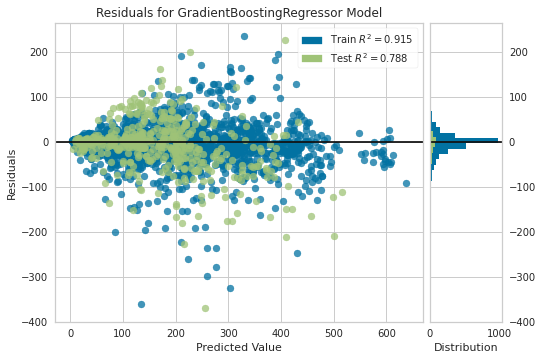

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [15]:
plot_model(best_gbr_model, plot='residuals') 

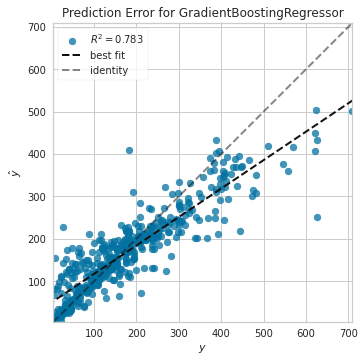

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(best_gbr_model, plot='error') 

In [19]:
#Intepret model canni be run for Tree models
#interpret_model(best_gbr_model)

#### PyCaret experiments with PCA, target transformations, low variance
#### Use PCA components to train

These are the components that StandardScaling creates which explain 70% of the variance in the data. 

#### Top 4 most important features in each component
===============================================
- Component 0: ['TOTALCOMPLETEDDEPTH_AVG', 'BOTTOMOFPERFORATEDINTERVAL_AVG', 'TOPOFPERFORATEDINTERVAL_AVG', 'STATICWATERLEVEL_AVG']
- Component 1: ['WELL_COUNT_DOMESTIC', 'CURRENT_DEPTH', 'GROUNDSURFACEELEVATION_AVG', 'WELL_COUNT_AGRICULTURE']
- Component 2: ['PCT_OF_CAPACITY', 'AVERAGE_YEARLY_PRECIPITATION', 'WELL_COUNT_AGRICULTURE', 'WELL_COUNT_DOMESTIC']
- Component 3: ['AVERAGE_YEARLY_PRECIPITATION', 'GROUNDSURFACEELEVATION_AVG', 'POPULATION_DENSITY', 'WELL_COUNT_DOMESTIC']
- Component 4: ['TOTALDRILLDEPTH_AVG', 'POPULATION_DENSITY', 'WELL_COUNT_AGRICULTURE', 'GROUNDSURFACEELEVATION_AVG']
- Component 5: ['POPULATION_DENSITY', 'TOTALDRILLDEPTH_AVG', 'PCT_OF_CAPACITY', 'CURRENT_DEPTH']

In [20]:
data_dir  = '../assets/train_test_target_shifted/'
file_name = 'X_target_shifted_pca.pickle'
pca_train_test_dict = read_target_shifted_pca_data(data_dir, file_name)

   
X_train_standardscaler_pca = pca_train_test_dict["X_train_pca"]
X_test_standardscaler_pca = pca_train_test_dict["X_test_pca"]

arr_train_y = y_train.values.reshape(y_train.values.shape[0], 1)
arr_test_y = y_test.values.reshape(y_test.values.shape[0], 1)

pca_train_standardscaler_df = pd.DataFrame(
    np.hstack((X_train_standardscaler_pca, arr_train_y)),
    columns=[
        "Component_0",
        "Component_1",
        "Component_2",
        "Component_3",
        "Component_4",
        "Component_5",
        "GSE_GWE_SHIFTED",
    ],
)
pca_test_standardscaler_df = pd.DataFrame(
    np.hstack((X_test_standardscaler_pca, arr_test_y)),
    columns=[
        "Component_0",
        "Component_1",
        "Component_2",
        "Component_3",
        "Component_4",
        "Component_5",
        "GSE_GWE_SHIFTED",
    ],
)


In [ ]:
target_normalized_exp = setup(
    pca_train_standardscaler_df,
    target="GSE_GWE_SHIFTED",
    preprocess=False,
    #Transform the target
    transform_target= True,
    train_size=1.0,
    test_data=pca_test_standardscaler_df,
    session_id=RANDOM_SEED,
    log_experiment=True,
    pca=True,
    pca_components=6,
    pca_method="linear",
    experiment_name="water_depth_pca_shifted"
)

,Description,Value
0,session_id,42
1,Target,GSE_GWE_SHIFTED
2,Original Data,"(2868, 7)"
3,Missing Values,False
4,Numeric Features,6
5,Categorical Features,0
6,Transformed Train Set,"(2868, 6)"
7,Transformed Test Set,"(478, 6)"
8,Shuffle Train-Test,True
9,Stratify Train-Test,False


INFO:logs:Logging experiment in MLFlow
Traceback (most recent call last):
  File "/root/venv/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 262, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/root/venv/lib/python3.9/site-packages/mlflow/store/tracking/file_store.py", line 341, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/root/venv/lib/python3.9/site-packages/mlflow/utils/file_utils.py", line 181, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.MissingConfigException: Yaml file '/work/milestone2_waterwells_deepnote/ml/mlruns/mlruns/meta.yaml' does not exist.
INFO:logs:SubProcess save_model() called ==================================
INFO:logs:Initializing save_model()
INFO:logs:save_model(model=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
         

In [21]:
pca_standardscaler_best = compare_models(['gbr', 'catboost', 'et', 'rf'],fold=15)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,28.9196,2601.7870,46.7651,0.7948,0.3143,0.2615,9.6873
gbr,Gradient Boosting Regressor,27.7455,2650.9132,46.7539,0.7933,0.3085,0.2402,1.2280
rf,Random Forest Regressor,28.8906,2563.8919,47.0132,0.7848,0.3130,0.2455,3.7733
et,Extra Trees Regressor,29.6769,2744.5302,48.8082,0.7730,0.3246,0.2611,2.0753


INFO:logs:create_model_container: 37
INFO:logs:master_model_container: 37
INFO:logs:display_container: 7
INFO:logs:PowerTransformedTargetRegressor(border_count=254, loss_function='RMSE',
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                random_state=42,
                                regressor=<catboost.core.CatBoostRegressor object at 0x7fba4b927d00>,
                                task_type='CPU', verbose=False)
INFO:logs:compare_models() succesfully completed......................................


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b042e2da-6536-449d-95b8-d85fa08825de' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>